In [37]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import PolynomialFeatures
from sklearn import model_selection, svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
# from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import category_encoders as ce

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE

import pickle

from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, precision_score, plot_confusion_matrix, plot_roc_curve, roc_curve

In [3]:
state = 1992

In [15]:
bank = pd.read_csv('bank_clean_out.csv')

In [17]:
bank

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,1,-1,0,0
4,35,management,married,tertiary,no,231,yes,no,unknown,5,may,1,-1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44918,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,3,-1,0,1
44919,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,2,-1,0,1
44920,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,5,184,3,1
44921,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,4,-1,0,0


PLAN

Impute
- education dan contact dengan mode (secondary dan cellular)

Encoder:
- education -> ordinal
- job, marital, default, housing, loan, contact -> onehot
- month -> binary

Oversampling -> SMOTE

Model
- Logistic Regression
- Random Forest
- XGBoost

Metrics -> pake f1

In [18]:
bank1 = bank.drop(['y'], axis=1)

In [19]:
X = bank1
y = bank['y']

In [21]:
#data splitting

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = state)

In [32]:
logit = LogisticRegression(random_state=state)
rfc = RandomForestClassifier(max_depth=10, random_state=state)
dtc = DecisionTreeClassifier(max_depth = 5, random_state = state)
smote = SMOTE(random_state = state)

In [28]:
ordinal_mapping = [
    {'col': 'education',
    'mapping': {None:0, 'primary': 1, 'secondary': 2, 'tertiary': 3}} # 'unknown': bank.education.mode
]
ordx = [[None,0], ['primary', 1], ['secondary', 2], ['tertiary', 3]]

onehot_pipeline = Pipeline([
    ('impute_cat', SimpleImputer(strategy='most_frequent', missing_values = 'unknown')),
    ('onehot', OneHotEncoder(drop='first'))
])
binary_pipeline = Pipeline([
    ('binary', ce.BinaryEncoder())
])

ordinal_pipeline = Pipeline([
    ('impute_cat', SimpleImputer(strategy='most_frequent', missing_values = 'unknown')),
    ('ordinal', OrdinalEncoder())
])

transformer = ColumnTransformer([
    ('onehot_pipe', onehot_pipeline, ['job', 'marital', 'default', 'housing', 'loan', 'contact']),
    ('binary_pipe', binary_pipeline, ['month']),
    ('ordinal_pipe', ordinal_pipeline, ['education'])
], remainder='passthrough')

In [29]:
#DTC Pipe
dtc_pipeline = Pipeline([
    ('transformer', transformer),
    ('rfe', RFE(dtc)),
    ('resampling', smote),
    ('clf', dtc)
])

In [34]:
#Logit Pipe
logit_pipeline = Pipeline([
    ('transformer', transformer),
    ('rfe', RFE(logit)),
    ('resampling', smote),
    ('clf', logit)
])

In [33]:
#RFC Pipe
rfc_pipeline = Pipeline([
    ('transformer', transformer),
    ('rfe', RFE(rfc)),
    ('resampling', smote),
    ('clf', rfc)
])

In [30]:
dtc_pipeline.get_params()

{'memory': None,
 'steps': [('transformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('onehot_pipe',
                                    Pipeline(steps=[('impute_cat',
                                                     SimpleImputer(missing_values='unknown',
                                                                   strategy='most_frequent')),
                                                    ('onehot',
                                                     OneHotEncoder(drop='first'))]),
                                    ['job', 'marital', 'default', 'housing',
                                     'loan', 'contact']),
                                   ('binary_pipe',
                                    Pipeline(steps=[('binary', BinaryEncoder())]),
                                    ['month']),
                                   ('ordinal_pipe',
                                    Pipeline(steps=[('impute_cat',
                    

In [35]:
logit_pipeline.get_params()

{'memory': None,
 'steps': [('transformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('onehot_pipe',
                                    Pipeline(steps=[('impute_cat',
                                                     SimpleImputer(missing_values='unknown',
                                                                   strategy='most_frequent')),
                                                    ('onehot',
                                                     OneHotEncoder(drop='first'))]),
                                    ['job', 'marital', 'default', 'housing',
                                     'loan', 'contact']),
                                   ('binary_pipe',
                                    Pipeline(steps=[('binary', BinaryEncoder())]),
                                    ['month']),
                                   ('ordinal_pipe',
                                    Pipeline(steps=[('impute_cat',
                    

In [36]:
rfc_pipeline.get_params()

{'memory': None,
 'steps': [('transformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('onehot_pipe',
                                    Pipeline(steps=[('impute_cat',
                                                     SimpleImputer(missing_values='unknown',
                                                                   strategy='most_frequent')),
                                                    ('onehot',
                                                     OneHotEncoder(drop='first'))]),
                                    ['job', 'marital', 'default', 'housing',
                                     'loan', 'contact']),
                                   ('binary_pipe',
                                    Pipeline(steps=[('binary', BinaryEncoder())]),
                                    ['month']),
                                   ('ordinal_pipe',
                                    Pipeline(steps=[('impute_cat',
                    

In [40]:
rs = RepeatedStratifiedKFold(n_splits=5, random_state=state)

dtc_score = cross_val_score(dtc_pipeline, X_train_val, y_train_val, scoring='f1', cv=rs, n_jobs=-1, verbose=1)
logit_score = cross_val_score(logit_pipeline, X_train_val, y_train_val, scoring='f1', cv=rs, n_jobs=-1, verbose=1)
rfc_score = cross_val_score(rfc_pipeline, X_train_val, y_train_val, scoring='f1', cv=rs, n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   17.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   54.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  8.1min finished


In [42]:
print('DTC Val Score:', dtc_score, '\nDTC Val Score: Mean', dtc_score.mean())

DTC Val Score: [0.28682171 0.31465517 0.29812734 0.3442623  0.35212248 0.29668675
 0.3122102  0.32885212 0.27097768 0.34888729 0.29057187 0.29971182
 0.36275862 0.36849711 0.34571429 0.31553785 0.27629513 0.3488544
 0.31386861 0.35934426 0.31716148 0.31428571 0.36798906 0.3348281
 0.25575448 0.3526245  0.31798561 0.38316401 0.29475309 0.31053036
 0.34107402 0.28776978 0.27208757 0.35459005 0.30466472 0.30349014
 0.31464174 0.26552795 0.33964912 0.32853899 0.34492754 0.29020194
 0.31994156 0.28379388 0.27412814 0.30046225 0.33241758 0.32517839
 0.31114435 0.33807031] 
DTC Val Score: Mean 0.3183226679763835


In [41]:
print('Logit Val Score:', logit_score, '\nLogit Val Score: Mean', logit_score.mean())

Logit Val Score: [0.29027963 0.28604185 0.29069767 0.2871179  0.29947368 0.28518124
 0.29351351 0.27858628 0.29975295 0.3043829  0.29814711 0.28657866
 0.28288932 0.29980276 0.29003181 0.28840463 0.2992641  0.27835616
 0.28325194 0.29967949 0.28463815 0.2767928  0.2920818  0.2922349
 0.3069917  0.27524387 0.28776978 0.30951009 0.29226361 0.28689655
 0.29557473 0.2837033  0.29056204 0.28360656 0.29032258 0.29072682
 0.28275688 0.28078685 0.29004329 0.29608939 0.2886049  0.28686327
 0.29606625 0.29063786 0.28328461 0.28847661 0.27927194 0.28262018
 0.2972332  0.30588235] 
Logit Val Score: Mean 0.29017940912636725


In [43]:
print('RFC Val Score:', rfc_score, '\nRFC Val Score: Mean', rfc_score.mean())

RFC Val Score: [0.35413417 0.33853354 0.3640553  0.36249015 0.36070606 0.35483871
 0.3417004  0.34118603 0.31146245 0.38392857 0.3446677  0.33667954
 0.34321373 0.39195231 0.37609562 0.38345865 0.32854864 0.35905512
 0.34290147 0.37557252 0.34123948 0.3431221  0.36882716 0.3541502
 0.34913112 0.34693878 0.34513941 0.40613027 0.32695375 0.36392157
 0.3671275  0.36890244 0.34892942 0.37645236 0.3427697  0.35135135
 0.37274863 0.36458333 0.35921569 0.34775767 0.38484848 0.34461538
 0.3592535  0.36671803 0.34379906 0.35857805 0.35505618 0.35349568
 0.37596302 0.37490318] 
RFC Val Score: Mean 0.3571560632673911


In [56]:
dtc_params = {
    'clf__max_depth': [4,5,6,7],
    'clf__min_samples_split': [6,7,8,9],
    'clf__criterion': ['entropy', 'gini'],
    'rfe__n_features_to_select': [None,5,6,7,8]
}

logit_params = {
    'clf__C': np.linspace(0,1,10),
    'clf__solver': ['lbfgs', 'liblinear', 'newton-cg']
}

rfc_params = {
    'clf__max_depth': np.arange(10,16),
    'clf__min_samples_split': np.arange(7,10)
}


In [48]:
skf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=state)

dtc_grid = GridSearchCV(dtc_pipeline, param_grid=dtc_params, scoring ='f1', n_jobs =-1, cv = skf, verbose=1)
dtc_grid.fit(X_train_val, y_train_val)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


C:\Users\user\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1992, shuffle=True),
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot_pipe',
                                                                         Pipeline(steps=[('impute_cat',
                                                                                          SimpleImputer(missing_values='unknown',
                                                                                                        strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(drop='first'))]),
                                                                         ['job',
                           

In [57]:
skf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=state)

logit_grid = GridSearchCV(logit_pipeline, param_grid=logit_params, scoring='f1', cv=skf, verbose=1, n_jobs=-1)
logit_grid.fit(X_train_val, y_train_val)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan 0.2913331  0.29086122 0.29086122
 0.29075082 0.29076628 0.29075082 0.29067526 0.29067526 0.29067526
 0.29069063 0.29069063 0.29069063 0.29072206 0.29072206 0.29072206
 0.29072206 0.29072206 0.29073752 0.29073752 0.29073752 0.29073752
 0.29072215 0.29073752 0.29073752 0.29072215 0.29073752 0.29072215]
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https:/

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1992, shuffle=True),
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot_pipe',
                                                                         Pipeline(steps=[('impute_cat',
                                                                                          SimpleImputer(missing_values='unknown',
                                                                                                        strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(drop='first'))]),
                                                                         ['job',
                           

In [58]:
rfc_grid = GridSearchCV(rfc_pipeline, param_grid=rfc_params, scoring='f1', cv=skf, verbose=1, n_jobs=-1)
rfc_grid.fit(X_train_val, y_train_val)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


C:\Users\user\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1992, shuffle=True),
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot_pipe',
                                                                         Pipeline(steps=[('impute_cat',
                                                                                          SimpleImputer(missing_values='unknown',
                                                                                                        strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(drop='first'))]),
                                                                         ['job',
                           

In [59]:
dtc_grid.best_params_

{'clf__criterion': 'gini',
 'clf__max_depth': 7,
 'clf__min_samples_split': 6,
 'rfe__n_features_to_select': 6}

In [60]:
logit_grid.best_params_

{'clf__C': 0.1111111111111111, 'clf__solver': 'lbfgs'}

In [61]:
rfc_grid.best_params_

{'clf__max_depth': 10, 'clf__min_samples_split': 7}

In [62]:
rfc_tuned = rfc_grid.best_estimator_
logit_tuned = logit_grid.best_estimator_
dtc_tuned = dtc_grid.best_estimator_

In [64]:
dtc_tuned_score = cross_val_score(dtc_tuned, X_train_val, y_train_val, scoring='f1', cv=rs, n_jobs=-1, verbose=1)
logit_tuned_score = cross_val_score(logit_tuned, X_train_val, y_train_val, scoring='f1', cv=rs, n_jobs=-1, verbose=1)
rfc_tuned_score = cross_val_score(rfc_tuned, X_train_val, y_train_val, scoring='f1', cv=rs, n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   15.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   52.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  7.6min finished


In [65]:
print('DTC Tuned Score:', dtc_tuned_score, '\nDTC Tuned Score: Mean', dtc_tuned_score.mean())

DTC Tuned Score: [0.36303191 0.32979388 0.39539347 0.40840446 0.39897172 0.3518608
 0.35862069 0.32187271 0.36716225 0.38930348 0.36204576 0.36765561
 0.37046467 0.4028691  0.39948619 0.36316806 0.3147482  0.39451728
 0.38317757 0.38381019 0.37427653 0.3518403  0.39453125 0.3417284
 0.37601918 0.35142469 0.39485981 0.40106952 0.37267905 0.37812128
 0.39067423 0.39215686 0.35301924 0.4090638  0.34508349 0.37805605
 0.38366818 0.3433908  0.38966203 0.36233611 0.41066021 0.37577816
 0.4060646  0.35809524 0.38420742 0.37715803 0.3653088  0.36016371
 0.39242219 0.39872204] 
DTC Tuned Score: Mean 0.3747719852249528


In [66]:
print('Logit Tuned Score:', logit_tuned_score, '\nLogit Tuned Score: Mean', logit_tuned_score.mean())

Logit Tuned Score: [0.29073482 0.28595989 0.29031407 0.28735005 0.30230665 0.28518124
 0.29335494 0.27858628 0.29991761 0.30391363 0.29845722 0.28594996
 0.28288932 0.29971831 0.28980132 0.28840463 0.29986395 0.27882772
 0.28314476 0.29877725 0.28463815 0.27577116 0.2920818  0.29215359
 0.30773348 0.27562582 0.28769313 0.30888697 0.29744793 0.28697329
 0.2961517  0.28331528 0.29056204 0.28345598 0.29024456 0.29187675
 0.28204482 0.28048452 0.29078983 0.29608939 0.28837457 0.28740263
 0.29591309 0.29063786 0.28313413 0.28825065 0.27865291 0.28262018
 0.29621849 0.30575437] 
Logit Tuned Score: Mean 0.2902886532670299


In [67]:
print('RFC Tuned Score:', rfc_tuned_score, '\nRFC Tuned Score: Mean', rfc_tuned_score.mean())

RFC Tuned Score: [0.34326019 0.34654235 0.3595679  0.36770584 0.35877863 0.35285054
 0.32703369 0.34747798 0.321513   0.37174721 0.33591331 0.3427697
 0.3374613  0.38599106 0.37658228 0.37972769 0.32324841 0.3568
 0.34461538 0.36643572 0.36036036 0.33877234 0.38102525 0.36146497
 0.34208433 0.34536892 0.34487952 0.40307692 0.3409629  0.36564224
 0.37413395 0.35846154 0.33816425 0.38264911 0.34039334 0.36591087
 0.38057948 0.36649215 0.36753446 0.343083   0.3756654  0.35103926
 0.35239567 0.35103926 0.34411997 0.34701782 0.34363225 0.35433071
 0.38181818 0.38437979] 
RFC Tuned Score: Mean 0.35665000743033887


In [68]:
cv_res_df = pd.DataFrame(dtc_grid.cv_results_)
cv_res_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__criterion,param_clf__max_depth,param_clf__min_samples_split,param_rfe__n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.765477,0.015837,0.046183,0.004215,entropy,4,6,None,"{'clf__criterion': 'entropy', 'clf__max_depth'...",0.304159,0.303156,0.239057,0.229289,0.349122,0.284957,0.044772,149
1,2.037869,0.042730,0.051867,0.007355,entropy,4,6,5,"{'clf__criterion': 'entropy', 'clf__max_depth'...",0.286381,0.254517,0.359582,0.353994,0.343968,0.319689,0.041748,117
2,2.007707,0.041151,0.047473,0.004305,entropy,4,6,6,"{'clf__criterion': 'entropy', 'clf__max_depth'...",0.300221,0.259317,0.350025,0.349222,0.360102,0.323777,0.038382,105
3,2.543362,0.252947,0.065850,0.006982,entropy,4,6,7,"{'clf__criterion': 'entropy', 'clf__max_depth'...",0.303455,0.258314,0.340665,0.229289,0.349122,0.296169,0.046353,137
4,2.818281,0.126502,0.072425,0.002650,entropy,4,6,8,"{'clf__criterion': 'entropy', 'clf__max_depth'...",0.302337,0.253344,0.239057,0.229289,0.357473,0.276300,0.047731,157


In [69]:
cv_res_df[cv_res_df['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__criterion,param_clf__max_depth,param_clf__min_samples_split,param_rfe__n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
142,3.091349,0.166038,0.073016,0.0064,gini,7,6,6,"{'clf__criterion': 'gini', 'clf__max_depth': 7...",0.363032,0.329794,0.395393,0.408404,0.398972,0.379119,0.029012,1


In [70]:
model_default = dtc_pipeline.fit(X_train_val, y_train_val)
y_pred_default = model_default.predict(X_test)

print(classification_report(y_test, y_pred_default))

C:\Users\user\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


              precision    recall  f1-score   support

           0       0.91      0.94      0.93      7934
           1       0.41      0.31      0.35      1051

    accuracy                           0.87      8985
   macro avg       0.66      0.63      0.64      8985
weighted avg       0.85      0.87      0.86      8985



In [71]:
#model 2: jadi lebih bagus
model_tuned = dtc_grid.best_estimator_.fit(X_train_val, y_train_val)
y_pred_tuned = model_tuned.predict(X_test)

print(classification_report(y_test, y_pred_tuned))

C:\Users\user\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


              precision    recall  f1-score   support

           0       0.92      0.92      0.92      7934
           1       0.41      0.39      0.40      1051

    accuracy                           0.86      8985
   macro avg       0.66      0.66      0.66      8985
weighted avg       0.86      0.86      0.86      8985



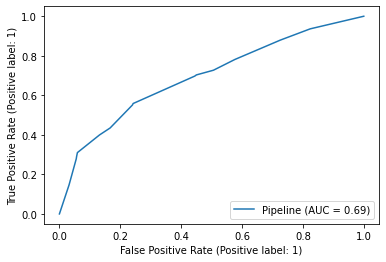

In [72]:
#membuat plot roc model1:

plot_roc_curve(model_default, X_test, y_test)

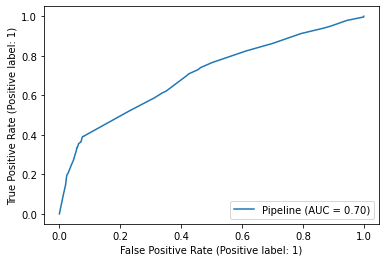

In [74]:
#membuat plot roc model2:

plot_roc_curve(model_tuned, X_test, y_test)

In [76]:
model = model_tuned

In [77]:
model.fit(X,y)

C:\Users\user\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot_pipe',
                                                  Pipeline(steps=[('impute_cat',
                                                                   SimpleImputer(missing_values='unknown',
                                                                                 strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['job', 'marital', 'default',
                                                   'housing', 'loan',
                                                   'contact']),
                                                 ('binary_pipe',
                                                  Pipeline(steps=[('binary',
              

In [78]:
filename = 'model.sav'
pickle.dump(model, open(filename, 'wb'))

In [79]:
openfile = 'model.sav'
loaded_model = pickle.load((open(openfile, 'rb')))
loaded_model

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot_pipe',
                                                  Pipeline(steps=[('impute_cat',
                                                                   SimpleImputer(missing_values='unknown',
                                                                                 strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['job', 'marital', 'default',
                                                   'housing', 'loan',
                                                   'contact']),
                                                 ('binary_pipe',
                                                  Pipeline(steps=[('binary',
              

Coba predik 1 df

In [89]:
test = pd.read_csv('test.csv', sep=';')

In [90]:
test

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
4518,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no


In [91]:
test.drop(columns = ['poutcome', 'duration'], inplace=True)

In [92]:
testx = test.drop(columns = 'y')
testy = test.y

In [93]:
testy.replace(['yes', 'no'], [1,0], inplace=True)

In [94]:
testy

0       0
1       0
2       0
3       0
4       0
       ..
4516    0
4517    0
4518    0
4519    0
4520    0
Name: y, Length: 4521, dtype: int64

In [95]:
y_pred_test = loaded_model.predict(testx)

In [96]:
results = pd.DataFrame({'id': testx.index, 'label' : y_pred_test})
results

,id,label
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
4516,4516,0
4517,4517,0
4518,4518,0
4519,4519,0


In [97]:
results['asli'] = testy
results[results['label'] != results['asli']]

,id,label,asli
5,5,1,0
19,19,1,0
24,24,1,0
27,27,1,0
33,33,0,1
...,...,...,...
4494,4494,0,1
4503,4503,0,1
4504,4504,0,1
4505,4505,0,1


In [98]:
747/4521

0.16522893165228933